In [46]:
import warnings
warnings.filterwarnings('ignore')

# Stacked Regressions to predict House Prices

**참고** : https://www.kaggle.com/serigne/stacked-regressions-top-4-on-leaderboard 를 보고 필사하였으며 스스로 번역을 하였고 중간 중간 좀 더 편리한 부분 혹은 바뀐부분은 수정하였음.

## 유용한 코드
1. [소수점 표시](#code1)
2. [조건을 이용하여 drop하는 방법](#code2)
3. [평균, 표준편차 표시](#code3)
4. [QQ-plot 코드](#code4)
5. [log(1+x)로 만들어주기](#code5)
6. [transform을 이용한 변환](#code6)
7. [LabelEncoding](#code7)
8. [skewed를 확인해주는 skew함수](#code8)
9. [BoxCox 변환](#code9)
10. [KFold, cross_val_score](#code11)
11. [Lightgbm에 대한 이해](http://machinelearningkorea.com/2019/09/25/lightgbm%EC%9D%98-%ED%95%B5%EC%8B%AC%EC%9D%B4%ED%95%B4/)
12. [out-of-folds predictions](#code12)

## 목차
- 1. [간단한 소개](#1)
- 2. [데이터 전처리](#2)
    - 2-1. Outliers
    - 2-2. Target Variables
    - 2-3. Feature engineering
- 3. [모델링](#3)
    - 3-1. Base Models
    - 3-2. Stacking Models
    - 3-3. Ensembling StackedRegressor, XGBoost and LightGBM

## 1. 간단한 소개<a name = '1'></a>
- [Comprehensive data exploration with Python](https://www.kaggle.com/pmarcelino/comprehensive-data-exploration-with-python) by Pedro Marcelino 를 참조하면 data analysis에 대한 대략적인 직관을 얻을 수 있음.
- [A study on Regression applied to the Ames dataset](https://www.kaggle.com/juliencs/a-study-on-regression-applied-to-the-ames-dataset) by Julien Cohen-Solal 를 참조하면 feature engineering과 선형 회귀 분석을 보다 깊게 들여다 볼 수 있다. 하지만 초보자들에게 그리 쉬운 과제는 아니다.
- [Regularized Linear Models](https://www.kaggle.com/apapiu/regularized-linear-models) by Alexandru Papiu 를 참조하면 Modelling과 Cross-validation에 대한 것을 알아갈 수 있다. 처음에 이를 알아가기에 적절한 커널이다.


더불어 지금 진행 중인 코딩은 초보자들에게 추천하지는 않으며 위에 커널들로부터(물론 다른 커널들 역시 좋은 커널들이 많다.) first insights를 먼저 얻는 것이 좋다.


first insights를 얻은 후에 [XGBoost + Lasso](https://www.kaggle.com/humananalog/xgboost-lasso) by Human Analog ( features engineering를 참고하면 좋다. )를 진행하면 좀 더 자신감을 얻을 수 있을 것이다.


이번 datset는 특히 다루기가 편리하며 여기서는 stacking model을 사용할 것이다. stacking model을 하기 위해 두 개의 stacking classes를 구축할 것이다. ( 가장 간단한 접근법과 덜 단순한 접근법 )


특히 여기서 feature engineering 경우 좀 더 단순할 것이다. ( 적어도 다른 좋은 커널들과 비교하자면 )
- 데이터를 순차적으로 진행하여 결측값을 imputing한다.
- 실제 범주형처럼 보이는 일부 숫자 변수를 변환한다.
- 레이블 순서 집합에 정보를 포함할 수 있는 일부 범주형 변수 인코딩
- Box Cox 변환 ( 로그 변환을 대신하여 사용하였다. ) : 이를 사용함으로써 전체적인 점수 및 cross-validation 점수에서 더 나은 결과를 주었다.
- 범주형 형상에 대한 더미 변수 가져오기.  


그 후에 많은 base model들을 선택할 것이다 ( 대부분 sklearn기반 모델 + DMLC의 XGBoost와 마이크로소프트의 LightGBM ), stacking이나 ensembling을 하기 전에 데이터에 대하여 cross-vadiate를 한다. 여기에서 핵심은 outlier에 대하여 견고하게 linear models를 만드는 것이다. 이것은 더 나은 결과를 가져다준다.

<a name = 'code1'></a>

In [47]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

color = sns.color_palette()
sns.set_style('darkgrid')

import warnings
def ignore_warn(*args, **kwargs) :
    pass
warnings.warn = ignore_warn

from scipy import stats
from scipy.stats import norm, skew
# 몇몇 통계량을 사용하기위해 쓰는 library이다.

pd.set_option('display.float_format', lambda x: '{:.3f}'.format(x))
# 소수점을 3째자리까지 나타내는 것이다.

#from subprocess import check_output # 실행되지 않음
#print(check_output(['ls', '../data/boston']).decode('utf-8'))
# Check the files available in the directory

In [48]:
train = pd.read_csv('../data/boston/train.csv')
test = pd.read_csv('../data/boston/test.csv')

In [49]:
train.head(3)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.000,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.000,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.000,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500


In [50]:
test.head(3)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.000,11622,Pave,NaN,Reg,Lvl,AllPub,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.000,14267,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.000,13830,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal


In [51]:
print('The train data size before dropping Id feature is : {} '.format(train.shape))
print('The test data size before dropping Id feature is : {} '.format(test.shape))

train_ID = train['Id']
test_ID = test['Id']

train.drop('Id', axis = 1, inplace = True)
test.drop('Id', axis = 1, inplace = True)

print('\nThe train data size after dropping Id feature is : {} '.format(train.shape))
print('The test data size after dropping Id feature is : {} '.format(test.shape))

The train data size before dropping Id feature is : (1460, 81) 
The test data size before dropping Id feature is : (1459, 80) 

The train data size after dropping Id feature is : (1460, 80) 
The test data size after dropping Id feature is : (1459, 79) 


## 2. 데이터 전처리 <a name = '2'></a>

### 2-1. Outliers

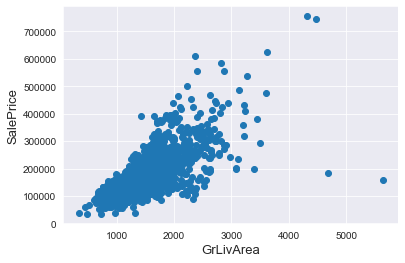

In [52]:
fig, ax = plt.subplots()
ax.scatter(x = train['GrLivArea'], y = train['SalePrice'])
plt.ylabel('SalePrice', fontsize = 13)
plt.xlabel('GrLivArea', fontsize = 13)
plt.show()

- 가격이 저렴한 경우에 GrLivArea가 대부분 모여있음을 볼 수 있다.
- outliers가 눈에 띄게 있으며 우리들은 그것들을 안전하게 삭제할 수 있다.

<a name = 'code2'></a>

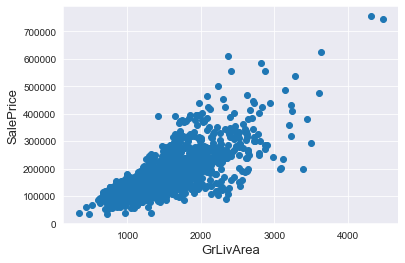

In [53]:
train = train.drop(train[(train['GrLivArea'] > 4000) & (train['SalePrice'] < 300000)].index)
# Deleting Outliers

fig, ax = plt.subplots()
ax.scatter(train['GrLivArea'], train['SalePrice'])
plt.ylabel('SalePrice', fontsize = 13)
plt.xlabel('GrLivArea', fontsize = 13)
plt.show()

**Note :**
Outliers를 제거하는 것이 항상 안전한 것은 아니다. 우리는 흔히 아주 크거나 아주 나쁠 때 ( 극도로 크거나 극도로 작을 때 ) outlier들을 삭제하기로 한다.

Training data에는 아마도 다른 outlier들이 더 있을 것이다.하지만 test data 역시 outlier가 존재할 수 있으므로 무작위로 삭제를 하는 것은 모델에 나쁜 영향을 미칠 수 있다. 그렇기 때문에 모든 outlier를 삭제하기 보다는 우리의 model을 좀 더 견고하게 만들기 위해 일부를 제거하는 것을 사용할 수 있다.

### 2-2. Target Variable

**SalePrice**는 우리가 예측해야할 변수이다. 이 변수에 대하여 분석을 진행하도록 하자.

<a name = 'code3'></a>
<a name = 'code4'></a>


 mu = 180932.92 and sigma = 79467.79



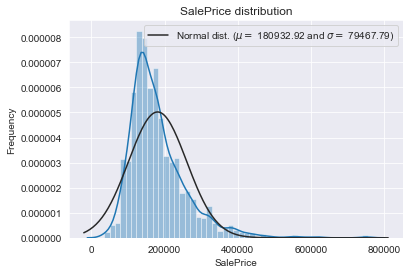

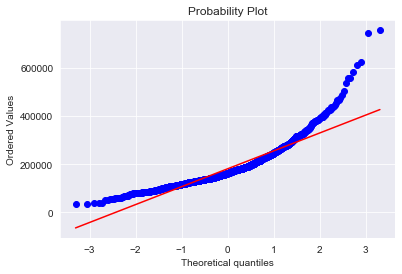

In [54]:
sns.distplot(train['SalePrice'], fit = norm);

(mu, sig) = norm.fit(train['SalePrice'])
print('\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sig))
# 평균과 표준편차를 얻는다

plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f})'.format(mu, sig)],
           loc = 'best')
plt.ylabel('Frequency')
plt.title('SalePrice distribution')
# 분포에 대한 그래프를 그린다

fig = plt.figure()
res = stats.probplot(train['SalePrice'], plot = plt)
plt.show()
# QQ-plot 그리기

- 위의 변수는 오른쪽으로 skewed 되어있음을 볼 수 있다.
- 선형모델의 경우 정규분포를 가정하는 것이 좋으므로 이 변수를 변환하여 정규분포를 따르게 만들 필요성이 있다.

**Log-Transformation of the target variable**<a name = '#code5'></a>


 mu = 12.02 and sigma = 0.40



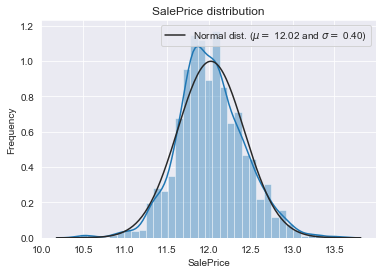

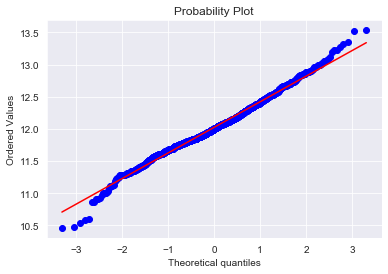

In [55]:
train['SalePrice'] = np.log1p(train['SalePrice'])
# 열 전체를 log(1+x)를 취해주기 위하여 numpy의 log1p를 사용한다.

sns.distplot(train['SalePrice'], fit = norm)
# 그래프를 그려서 분포를 확인한다.

(mu, sig) = norm.fit(train['SalePrice'])
print('\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sig))

plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f})'.format(mu, sig)],
           loc = 'best')
plt.ylabel('Frequency')
plt.title('SalePrice distribution')

fig = plt.figure()
res = stats.probplot(train['SalePrice'], plot = plt)
plt.show()

- skew되어있던 것이 바로 잡히고 정규분포를 따르는 것을 볼 수 있다.

### 2-3. Feature engineering

먼저 train set과 test set을 합치도록 하자.

In [56]:
ntrain = train.shape[0]
ntest = test.shape[0]
y_train = train.SalePrice.values
all_data = pd.concat([train, test]).reset_index(drop = True)
all_data.drop(['SalePrice'], axis = 1, inplace = True)
print('all_data size is : {}'.format(all_data.shape))

all_data size is : (2917, 79)


#### Missing Data

In [57]:
all_data_na = (all_data.isnull().sum() / len(all_data)) * 100
all_data_na = all_data_na.drop(all_data_na[all_data_na == 0].index).sort_values(ascending = False)[:30]
missing_data = pd.DataFrame({'MIssing Ratio' : all_data_na})
missing_data.head(20)

,MIssing Ratio
PoolQC,99.691
MiscFeature,96.400
Alley,93.212
Fence,80.425
FireplaceQu,48.680
LotFrontage,16.661
GarageQual,5.451
GarageCond,5.451
GarageFinish,5.451
GarageYrBlt,5.451


Text(0.5, 1.0, 'Percent missing data by feature')

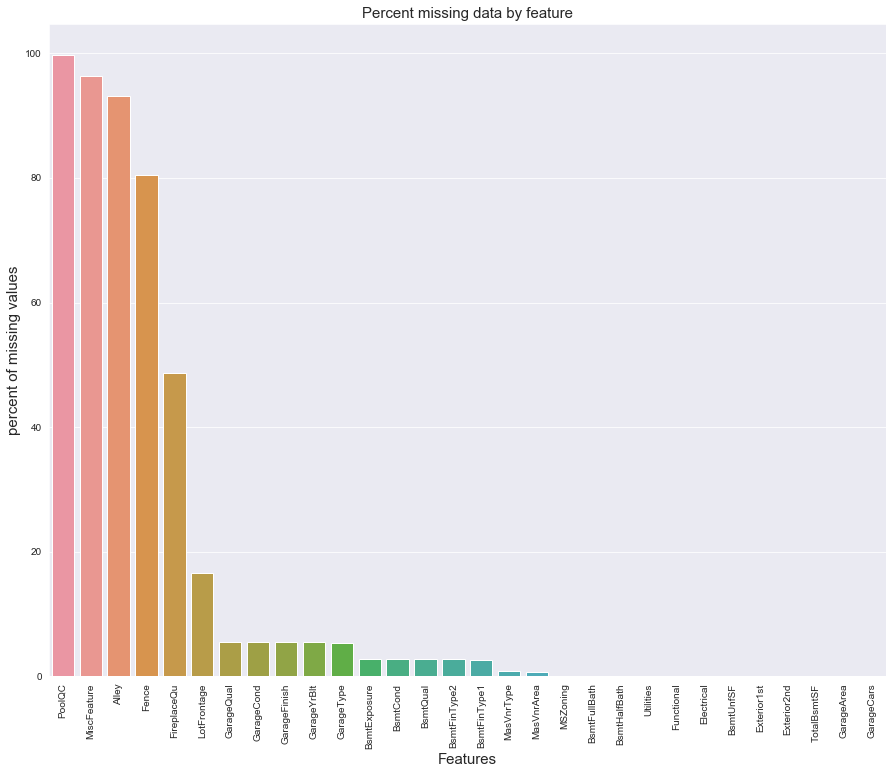

In [58]:
f, ax = plt.subplots(figsize =(15, 12))
plt.xticks(rotation = '90')
sns.barplot(x = all_data_na.index, y = all_data_na)
plt.xlabel('Features', fontsize = 15)
plt.ylabel('percent of missing values', fontsize = 15)
plt.title('Percent missing data by feature', fontsize  = 15)

#### Data Correlation

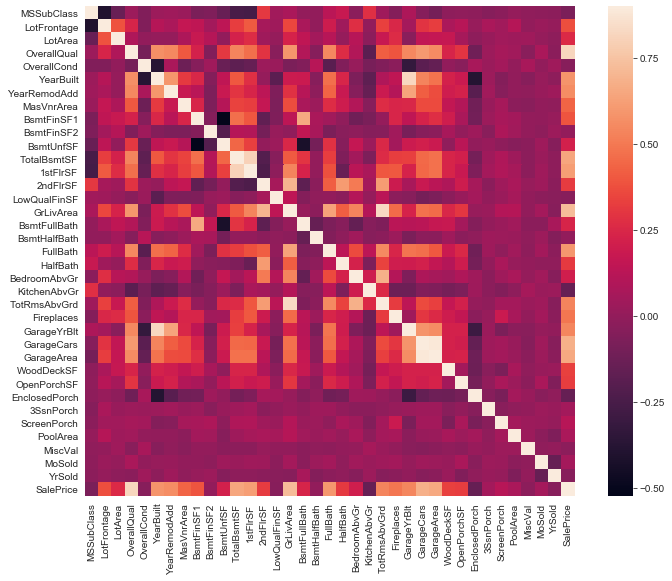

In [59]:
corrmat = train.corr()
plt.subplots(figsize = (12, 9))
sns.heatmap(corrmat, vmax = 0.9, square = True)

#### Imputing missing values
누락된 값이 있는 feature를 순차적으로 proceeding하여 impute하도록 한다.

**위의 결측치 분포 그래프 및 각 변수들의 특징들로부터 다음을 결정하였다.**

* **PoolQC :** 데이터 설명에 따르면 결측값은 '풀 없음'을 뜻한다고 한다. 대다수의 주택에는 풀이 없다는 것을 생각했을 때 말이 되는 결측값이다. 결측치를 None값으로 대채하도록 한다.  
* **MiscFeature :** 데이터 설명에 따르면 결측값은 'misc가 없음'을 의미한다고 한다. 이것 역시 None값으로 대채하도록 하자.도록 하자.  
* **Alley :** 데이터 설명에 따르면 결측값은 '골목 없음'을 나타낸다. 위와같이 처리하도록하자.  
* **Fence :** 데이터 설명에 따르면 결측값은 '펜스 없음'을 나타낸다. 위처럼 처리하자.
* **FireplaceQu :** 데이터 설명에 따르면 결측값은 '벽난로 없음'을 나타낸다. 위처럼 처리하자.
* **GarageType, GarageFinish GarageQual and GarageCond :** 결측치를 None값으로 대채하도록 한다. 
* **BsmtQual, BsmtCond, BsmtExposure, BsmtFinType1, BsmtFinType2 :** 이 categorical 지하실 관련 변수들은 결측치를 가질 경우 지하실이 없다는 것을 의미한다. 즉, 모두 결측값을 가질경우 None으로 나타내도록 한다.
* **MSSubClass :** 이 값이 결측값을 가진다는 것은 Building class가 없다는 것이다. 즉, 결측값을 가질 경우 None값으로 처리하도록 한다.

In [60]:
for col in ('PoolQC', 'MiscFeature', 'Alley', 'Fence', 'FireplaceQu',
            'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond',
            'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1',
            'BsmtFinType2', 'MSSubClass') :
    all_data[col] = all_data[col].fillna('None')

* **LotFrontage :** 주택재산과 관련된 각 도로의 면적은 이웃의 주택들과 유사한 면적을 가지고 있을 가능성이 높다. 그러므로 우리는 이웃의 중앙값으로 결측값을 채울 것이다. <a name = 'code6'></a>

In [61]:
all_data['LotFrontage'] = all_data.groupby('Neighborhood')['LotFrontage']\
    .transform(lambda x: x.fillna(x.median()))

* **GarageYrBlt, GarageArea, GarageCars :** 차고가 없다는 것은 그 차고에 차가 없다는 의미이므로 결측값을 0으로 채우도록 한다.
* **BsmtFinSF1, BsmtFinSF2, BsmtUnfSF, TotalBsmtSF, BsmtFullBath, BsmtHalfBath :** 이들은 지하가 없으므로 지하에 있는 이들의 개수 역시 없을 것이므로 0으로 대채하도록한다.

In [62]:
for col in ('GarageYrBlt', 'GarageArea', 'GarageCars',
            'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF',
            'BsmtFullBath', 'BsmtHalfBath') :
    all_data[col] = all_data[col].fillna(0)

* **MasVnrArea and MasVnrType :** 이 값이 결측치라는 것은 결측치를 가지는 집들은 masonry veneer를 가지고 있지 않음을 뜻하므로 area는 0으로 type의 경우 None으로 결측치를 채우도록 한다.

In [63]:
all_data['MasVnrArea'] = all_data['MasVnrArea'].fillna(0)
all_data['MasVnrType'] = all_data['MasVnrType'].fillna(0)

**Mode값으로 결측치를 채우는 것은 대부분 결측치가 그리 많지 않을 경우이다.**
* **MSZoning(The general zoning classification) :** 가장 많이 나온 'RL'로 결측값을 채울 것이다.
* **Electrical :** 이 값이 결측치를 가진다면 가장 흔하게 등장하는 'SBrkr'로 결측치를 채울 것이다.
* **KitchenQual :** Electrical과 마찬가지로 결측치가 하나밖에 없다. 그러므로 가장 많이 등장하는 'TA'값으로 결측치를 채우도록 한다.
* **Exterior1st and Exterior2nd :** Exterior 1과 2 모두 결측치가 1개 뿐이다. 그러므로 최빈값으로 결측치를 채우도록 한다.
* **SaleType :** 이 값 시 최빈값인 'WD'로 결측치를 채우도록 한다.

In [64]:
for col in ('MSZoning', 'Electrical', 'KitchenQual',
           'Exterior1st', 'Exterior2nd', 'SaleType') :
    all_data[col] = all_data[col].fillna(all_data[col].mode()[0])

* **Utilities :** 이 값은 하나의 'NoSeWa'와 두 개의 결측치를 제외한 모든 값이 'AllPub'이다. 그러므로 이 변수는 모델링을 구축하는데 있어서 그리 좋을 것 같지 않다. 그러므로 안전하게 삭제하도록 한다.

In [65]:
all_data = all_data.drop(['Utilities'], axis = 1)

* **Functional :** 데이터 설명은 결측치가 'typical'을 의미한다고 한다. 결측치를 'Typ'로 채워주도록 하자. 

In [66]:
all_data['Functional'] = all_data['Functional'].fillna('Typ')

**결측치가 남아있는지 확인해주도록 하자.**

In [67]:
all_data_na = (all_data.isnull().sum() / len(all_data)) * 100
all_data_na = all_data_na.drop(all_data_na[all_data_na == 0].index).sort_values(ascending = False)
missing_data = pd.DataFrame({'Missing Ratio' : all_data_na})
missing_data.head()

,Missing Ratio


결측치가 남아있지 않음을 알 수 있다.

#### More Features engineering

몇몇 numerical 변수들을 categorial변수들로 변경해주도록 하자.

In [68]:
# MSSubClass는 Building class를 의미한다.
all_data['MSSubClass'] = all_data['MSSubClass'].apply(str)

# OverallCond 변수도 categorical 변수로 변경해주자.
all_data['OverallCond'] = all_data['OverallCond'].astype(str)

# Year, Month sold 들드 categorical 변수로 변경해주도록 하자.
all_data['YrSold'] = all_data['YrSold'].astype(str)
all_data['MoSold'] = all_data['MoSold'].astype(str)

#### 순서 정보를 가지고 있는 몇몇 categorical 변수들을 Label Encoding해주도록 하자. <a name = 'code7'></a>
[LabelEncoding 간단한 예시 및 소개](https://m.blog.naver.com/PostView.nhn?blogId=wideeyed&logNo=221592651246&proxyReferer=https:%2F%2Fwww.google.com%2F)  
Label Encoding은 categorical 변수들을 숫자형으로 숫자를 부여하여 바꿔주는 것이다.


In [69]:
from sklearn.preprocessing import LabelEncoder
cols = ('FireplaceQu', 'BsmtQual', 'BsmtCond', 'GarageQual', 'GarageCond', 
        'ExterQual', 'ExterCond','HeatingQC', 'PoolQC', 'KitchenQual', 'BsmtFinType1', 
        'BsmtFinType2', 'Functional', 'Fence', 'BsmtExposure', 'GarageFinish', 'LandSlope',
        'LotShape', 'PavedDrive', 'Street', 'Alley', 'CentralAir', 'MSSubClass', 'OverallCond', 
        'YrSold', 'MoSold')
for c in cols :
    lbl = LabelEncoder()
    lbl.fit(list(all_data[c].values))
    all_data[c] = lbl.transform(list(all_data[c].values))

**Adding one more important feature**

집 값을 결정하는 데는 면적 관련 특징이 매우 중요하기 때문에 각 주택의 지하 1층과 2층의 총면적을 나타내는 feature를 추구하도록 한다.

In [70]:
all_data['TotalSF'] = all_data['TotalBsmtSF'] + all_data['1stFlrSF'] + all_data['2ndFlrSF']
# 지하와 1층 그리고 2츠으이 면적을 더하여 하나의 칼럼으로 나타낸다.

**Skewed features**<a name = 'code8'></a>

In [71]:
numeric_feats = all_data.dtypes[all_data.dtypes != 'object'].index

# 모든 Numeric 변수에 대하여 skewed인지 확인한다.
skewed_feats = all_data[numeric_feats].apply(lambda x: skew(x.dropna())).sort_values(ascending = False)
print('\nSkew in numerical feature: \n')
skewness = pd.DataFrame({'Skew' : skewed_feats})
skewness.head(3)


Skew in numerical feature: 



,Skew
MiscVal,21.940
PoolArea,17.689
LotArea,13.109


**(매우) Skewed한 feature에 대한 Box Cox 변환** <a name = 'code9'></a>

* 우리는 1+x의 Box-Cox 변환을 계산하는 scipy함수 boxcox1p를 사용하도록 한다.
* '$\lambda$=0'을 설정하는 것은 target variable에 대해 위에서 사용한 log1p와 동일하다는 점에 유의하자.
* Box Cox 변환에 대한 세부사항은 [여기](http://onlinestatbook.com/2/transformations/box-cox.html)에서 확인하도록 하자.
* scipy함수에 대한 세부사항은 [여기](https://docs.scipy.org/doc/scipy-0.19.0/reference/generated/scipy.special.boxcox1p.html)에서 확인하도록 하자.

In [72]:
skewness = skewness[abs(skewness) > 0.75]
print('There are {} skewed numerical features to Box Cox transform'.format(skewness.shape[0]))

from scipy.special import boxcox1p

skewed_features = skewness.index
lam = 0.15

for feat in skewed_features :
    all_data[feat] += 1
    all_data[feat]  = boxcox1p(all_data[feat], lam)

There are 59 skewed numerical features to Box Cox transform


**Getting dummy categorical features** <a name = 'code10'></a>
* 'pd.get_dummies'는 원-핫 인코딩을 해준다. 자세한 사항은 [여기](https://mizykk.tistory.com/13)에서 살펴보도록 하자.

In [73]:
all_data = pd.get_dummies(all_data)
print(all_data.shape)

(2917, 221)


In [74]:
train = all_data[:ntrain]
test = all_data[ntrain:]

## 3. Modelling <a name = '3'></a>

In [75]:
from sklearn.linear_model import ElasticNet, Lasso, BayesianRidge, LassoLarsIC
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error
import xgboost as xgb
import lightgbm as lgb

**Define a cross validation strategy**

우리는 sklearn에 있는 **cross_val_score**함수를 사용한다. 하지만 이 함수는 shuffle 기능이 없기 때문에 cross-validation을 하기 전에 데이터 set을 섞어주기 위해 코드 한 줄을 추가하도록 한다.<a name = 'code11'></a>

In [76]:
n_folds = 5

def rmsle_cv(model) :
    kf = KFold(n_folds, shuffle = True,
               random_state = 42).get_n_splits(train.values)
    rmse = np.sqrt(-cross_val_score(model, train.values, y_train, scoring = 'neg_mean_squared_error',
                                    cv = kf))
    return(rmse)

### 3-1. Base Models

* **LASSO Regression** :  
LASSO Model은 **이상치에 매우 민감하다.** 그래서 우리는 이상치에 견고하게 만들어 줄 필요가 있다. 이상치에 견고하게 만들어주기 위해 sklearn의 **Robustscaler()**를 사용할 것이다.

In [77]:
lasso = make_pipeline(RobustScaler(), Lasso(alpha = 0.0005, random_state = 1))

* **Elastic Net Regression** :
이것 역시 이상치에 더 견고하게 만들어준다.

In [78]:
ENet = make_pipeline(RobustScaler(), ElasticNet(alpha = 0.0005, l1_ratio = .9,
                                                 random_state = 3))

* **Kernel Ridge Regression** :

In [79]:
KRR = KernelRidge(alpha = 0.6, kernel = 'polynomial', degree = 2, coef0 = 2.5)

* **Gradient Boosting Regression** :
**huber** loss와 함께 이상치에 대하여 더 견고하게 만들어준다.

In [80]:
GBoost = GradientBoostingRegressor(n_estimators = 3000, learning_rate = 0.05,
                                   max_depth = 4, max_features = 'sqrt',
                                   min_samples_leaf = 15, min_samples_split = 10,
                                   loss = 'huber', random_state = 5)

* **XGBoost** :

In [81]:
model_xgb = xgb.XGBRegressor(colsample_bytree = 0.4603, gamma = 0.0468, 
                             learning_rate = 0.05, max_depth = 3, 
                             min_child_weight = 1.7817, n_estimators = 2200,
                             reg_alpha = 0.4640, reg_lambda = 0.8571,
                             subsample = 0.5213, random_state = 7)

* **LightGBM** :

In [82]:
model_lgb = lgb.LGBMRegressor(objective = 'regression', num_leaves = 5,
                              learning_rate = 0.05, n_estimators = 720,
                              max_bin = 55, bagging_fraction = 0.8,
                              bagging_freq = 5, feature_fraction = 0.2319,
                              feature_fraction_seed = 9, bagging_seed = 9,
                              min_data_in_leaf = 6, min_sum_hessian_in_leaf = 11)

**Base Models Scores**

cross-validation rmsle error를 평가하기위해 데이터에서 base model들이 어떻게 수행되는지 확인해보자.

In [83]:
models = [lasso, ENet, KRR, GBoost, model_xgb, model_lgb]
names = ['Lasso', 'ElasticNet', 'Kernel Ridge', 'Gradient Boosting',
         'Xgboost', 'LGBM']

In [84]:
for i, model in enumerate(models) :
    score = rmsle_cv(model)
    print('{} score : {:.4f} ({:.4f})\n'.format(names[i], score.mean(), score.std()))

Lasso score : 0.1113 (0.0072)

ElasticNet score : 0.1113 (0.0073)

Kernel Ridge score : 0.1145 (0.0074)

Gradient Boosting score : 0.1159 (0.0077)

Xgboost score : 0.1159 (0.0075)

[LightGBM] [Warning] feature_fraction is set=0.2319, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2319
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=11, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=11
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.2319, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2319
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be

### 3-2. Stacking Models

Simplest Stacking 접근 : Averaging base models

우리는 기본 모델을 평균화하는 가장 간단한 접근방법으로 시작한다. 새로운 클래스를 구축하여 우리의 모델과 더불어 캡슐화 및 코드 재사용을 확대한다.

**Averaged base models class**

In [85]:
class AveragingModels(BaseEstimator, RegressorMixin, TransformerMixin) :
    def __init__(self, models) :
        self.models = models
        
    # 데이터를 저장할 원본 모델의 복사본을 정의한다.
    def fit(self, X, y) :
        self.models_ = [clone(x) for x in self.models]
        
        # 복사된 base model들을 훈련한다.
        for model in self.models_ :
            model.fit(X, y)
            
        return self
    
    # 복제된 모델에 대한 예측을 하고 평균을 낸다.
    def predict(self, X) :
        predictions = np.column_stack([
            model.predict(X) for model in self.models_
        ])
        return np.mean(predictions, axis = 1)

**Averaged Base Models Score**

우리는 **ENet, GBoost, KRR, Lasso**들의 평균을 여기서 구할 것이다. 물론 우리는 쉽게 더 많은 모델을 혼합해서 추가할 수 있다.

In [86]:
averaged_models = AveragingModels(models = (ENet, GBoost, KRR, lasso))

score = rmsle_cv(averaged_models)
print(' Averaged base models score: {:.4f} ({:.4f})\n'.format(score.mean(), score.std()))

 Averaged base models score: 0.1084 (0.0074)



가장 간단한 stacking approach라도 점수를 향상시켜준다는 것을 볼 수 있다. 이것은 우리가 더 나아가 단순하지 않은 stacking approach를 진행하도록 장려한다.




**Less Simple Stacking : Adding a Meta-Model**
<a name = 'code12'></a>



이 접근법에서는 Averaged Base Models에 Meta Model을 추가하고, Meta Model을 훈련시키기 위해 Base Model의 out-of-folds predictions를 사용할 것이다.  


- 훈련 부분의 절차는 다음과 같이 설명할 수 있다.
    1. 전체 교육 세트를 두 개의 분리되어진 세트로 분할한다, ( **train**과 **holdout**이 있다. )
    2. 첫 번째로는 몇몇 Base Model들을 훈련시켜라. ( **train** )
    3. 두 번째로는 몇몇 Base Model들을 테스트하라. ( **holdhout** )
    4. input값으로서 (3)에서 구해진 예측값을 사용(out-of-folds predictions라고 한다.)하고 정확히 응답한 것(Target Variables)들을 출력물로 사용하여 **Meta Model**이라 불리는 상위 레벨 학습자를 훈련시킨다.  
    
 
처음의 3단계는 반복적으로 이뤄진다. 5-fold stacking을 생각해 보았을 때, 우리는 먼저 training data를 5개의 folds로 나누었다. 그 후, 5번을 반복한다. 각 반복에서, 우리는 4개의 folds에서의 모든 base model을 훈련시키고 나머지 fold(holdout fold)에 대하여 예측한다.


따라서, 우리는 5번 반복한 후에 전체 데이터가 4번째 단계에서 우리의 Meta Model을 훈련시키기 위한 새로운 특징으로서 사용할 out-of-folds predictions가 사용되곤 하는 것을 확신할 수 있을 것이다.


예측 부분의 경우, 우리는 test 데이터에 있느느 모든 Base Model들의 예측을 평균내어 **Meta features**로서 사용하였고, 최종 예측은 Meta Model을 사용하여 수행되었다.

더 구체적으로 알아보기 위하여 이후에 [여기](https://machinelearningmastery.com/out-of-fold-predictions-in-machine-learning/)를 참고해서 out-of-folds predictions에 대하여 알아보자.

<img src="../images/kfolds_images.png" style="width:500;height:200px;">


Image taken from [Faron](https://www.kaggle.com/getting-started/18153#post103381)

**Stacking Averaged Models Class**

In [92]:
class StackingAveragedModels(BaseEstimator, RegressorMixin, TransformerMixin) :
    def __init__(self, base_models, meta_model, n_folds = 5) :
        self.base_models = base_models
        self.meta_model = meta_model
        self.n_folds = n_folds
        
    # 기존의 모델의 복사본에 다시 fit시킬 것이다.
    def fit(self, X, y) :
        self.base_models_ = [list() for x in self.base_models]
        self.meta_model_ = clone(self.meta_model)
        kfold = KFold(n_splits = self.n_folds, shuffle = True, random_state = 156)
        
        # 복사된 Base Model들을 훈려녀시킨 후 out-of-fold predictions를 만든다.
        # 복사된 Meta Model을 훈련시킬 필요가 있다.
        out_of_fold_predictions = np.zeros((X.shape[0], len(self.base_models)))
        
        for i, model in enumerate(self.base_models) :
            for train_index, holdout_index in kfold.split(X, y) :
                instance = clone(model)
                self.base_models_[i].append(instance)
                instance.fit(X[train_index], y[train_index])
                y_pred = instance.predict(X[holdout_index])
                out_of_fold_predictions[holdout_index, i] = y_pred
                
        # 새로운 feature로서 out-of-fold predictions를 사용하여 복사된 Meta Model을 훈련시켜준다.
        self.meta_model_.fit(out_of_fold_predictions, y)
        return self
    
    # test 데이터에 대한 모든 Base Model의 예측을 수행하고 그에 대한 평균 예측을
    # Meta Model에 의해 수행되어지는 최종 예측에 대한 Meta features로 사용한다.
    def predict(self, X) :
        meta_features = np.column_stack([
            np.column_stack([model.predict(X) for model in base_models]).mean(axis = 1)\
        for base_models in self.base_models_ ])
        
        return self.meta_model_.predict(meta_features)

**Stacking Averaged models Score**

(같은 수의 모델을 사용하여)두 개의 접근법을 비교하기 위해, 우리는 단지 Enet,KRR, Gboost의 평균을 사용하고 거기에 Lasso를 Meta Model로서 추가할 것이다.

In [93]:
stacked_averaged_models = StackingAveragedModels(base_models = (ENet, GBoost, KRR),
                                                 meta_model = lasso)
score = rmsle_cv(stacked_averaged_models)
print('Stacking Averaged Models Score: {:.4f} ({:.4f})'.format(score.mean(),
                                                               score.std()))

Stacking Averaged Models Score: 0.1083 (0.0071)


우리는 meta learner를 추가함으로서 더 좋은 점수를 얻을 수 있다.

### 3-3. Ensembling StackedRegressor, XGBoost and LightGBM

우리는 **XGBoost**, **LightGBM**을 이전에 정의되어진 **StackedRegressor**에 더한다.

먼저 rmsle 평가 함수를 정의한다.

In [97]:
def rmsle(y, y_pred) :
    return np.sqrt(mean_squared_error(y, y_pred))

**Final Training and Prediction**


**StackedRegressor :**

In [98]:
stacked_averaged_models.fit(train.values, y_train)
stacked_train_pred = stacked_averaged_models.predict(train.values)
stacked_pred = np.expm1(stacked_averaged_models.predict(test.values))
print(rmsle(y_train, stacked_train_pred))

0.08129696338959644


**XGBoost :**

In [99]:
model_xgb.fit(train, y_train)
xgb_train_pred = model_xgb.predict(train)
xgb_pred = np.expm1(model_xgb.predict(test))
print(rmsle(y_train, xgb_train_pred))

0.07880067849464593


**LightGBM :**

In [100]:
model_lgb.fit(train, y_train)
lgb_train_pred = model_lgb.predict(train)
lgb_pred = np.expm1(model_lgb.predict(test.values))
print(rmsle(y_train, lgb_train_pred))

[LightGBM] [Warning] feature_fraction is set=0.2319, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2319
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=11, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=11
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
0.07156748887206583


**평균 산출할 때 전체 Train 데이터에서의 RMSE :**

In [101]:
print('RMSLE score on train data :')
print(rmsle(y_train, stacked_train_pred*0.7 + 
               xgb_train_pred*0.15 + lgb_train_pred * 0.15))

RMSLE score on train data :
0.077449893186096


**Ensemble prediction :**

In [102]:
ensemble = stacked_pred*0.7 + xgb_pred*0.15 + lgb_pred*0.15

**Submission**